In [ ]:
# * The MIT License (MIT) Copyright (c) 2017 by David Bird.
# * The formulation and display of an AUdio Spectrum using an ESp8266 or ESP32 and SSD1306 or SH1106 OLED Display using a Fast Fourier Transform
# * Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files
# * (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge,
# * publish, distribute, but not to use it commercially for profit making or to sub-license and/or to sell copies of the Software or to
# * permit persons to whom the Software is furnished to do so, subject to the following conditions:
# * The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
# * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
# * OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE
# * LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# * CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
# * See more at http://dsbird.org.uk

#!/usr/bin/env python3
# encoding: utf-8


## Importing libraries

In [10]:
import sys,os,json
import time
from time import sleep
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt

fichier: --ip=127.0.0.1
final: --ip=127.0.0_final.1
{"filename": "--ip=127.0.0.1", "output": "--ip=127.0.0_final.1", "count": 0}


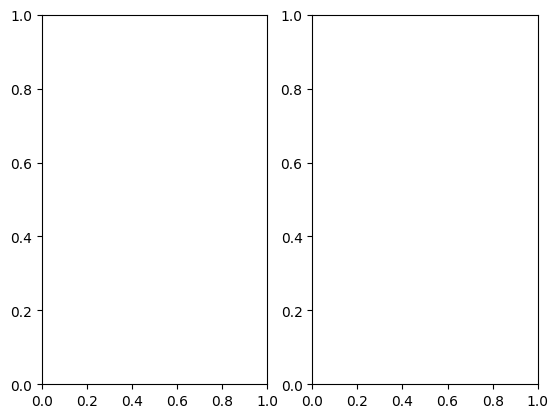

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2) # create subplots
coor_crop = [] # liste des coordonnées des crops
compte_crop = [] # N° des crops

# folder= "./tmp/test/british_cat/"
# folder= "C:/Users/Bernard/Documents/Scan_300ppp/crop_a_tester/crops_22/"
# folder= "C:/Users/Bernard/Documents/Scan_300ppp/faire_crop/filtre_a_crop/"
# folder1= "C:/Users/Bernard/Documents/Scan_300ppp/faire_crop/filtre_a_crop_1/"
folder= "E:/scan_13_01_2023/filtre_a_crop/"
folder1= "E:/scan_13_01_2023/filtre_a_crop_1/"
dim_crop = 22 # demi-largeur du crop 22 X 22
try:    
    filename = sys.argv[1]
    name, ext = os.path.splitext(sys.argv[1])
    output = name + '_final' + ext
    data = {'filename': filename, 'output': output, 'count': 0}
    print("fichier:", filename)
    print("final:", output)
    print(json.dumps(data))
except IndexError:
    print("missing filename")
    sys.exit()



In [ ]:

# https://www.codetd.com/en/article/12003434	
#print ('type x,y,srcW,refW,srcH,refH', x,type(x),y,type(y),srcW,type(srcW),refW,type(refW),srcH,type(srcH),refH,type(refH))
def addWeightedSmallImgToLargeImg(largeImg,alpha,smallImg,beta,gamma=0.0,regionTopLeftPos=(0,0)):
	srcW, srcH = largeImg.shape[1::-1]
	refW, refH = smallImg.shape[1::-1]
	y,x =  regionTopLeftPos
	# print ('type x,y,srcW,refW,srcH,refH', x,type(x),y,type(y),srcW,type(srcW),refW,type(refW),srcH,type(srcH),refH,type(refH))
	if (refW>srcW) or (refH>srcH):
		#raise ValueError("img2's size must less than or equal to img1")
		raise ValueError(f"img2's size {smallImg.shape[1::-1]} must less than or equal to img1's size {largeImg.shape[1::-1]}")
	else:
		if (x+refW)>srcW:
			x = str(srcW-refW)
		if (y+refH)>srcH:
			y = str(srcH-refH)
		destImg = np.array(largeImg)
		x1 = int(x)
		y1 = int(y)
		x2 = int(x)+refW
		y2 = int(y)+refH
		# print ('print 1 x1,x2,y1,y2', x1,type(x1),x2,type(x2),y1,type(y1),y2,type(y2))				
		tmpSrcImg = destImg[y1:y2,x1:x2]
		tmpImg = cv2.addWeighted(tmpSrcImg, alpha, smallImg, beta,gamma)
		destImg[y1:y2,x1:x2] = tmpImg
		return destImg

def mon_resize (image,taille):
	width = int(image.shape[1] * taille / 100)
	height = int(image.shape[0] * taille / 100)
	dsize = (width, height)	
	output = cv2.resize(image, dsize)
	return output

def insertion(points,compte_crop,ou_pas,h1,cpt) : 
    # insertion dans la page "blanche" des découpes de l'image d'origine autour des varroas détectés 
    # https://stackoverflow.com/questions/35884409/how-to-extract-x-y-coordinates-from-opencv-cv2-keypoint-object/35884644
    # RETREIVE KEYPOINTS COORDINATES AND DRAW MANUALLY
    # création d'une page blanche
    data['image_height'] = workingImage.shape[0]
    data['image_width'] = workingImage.shape[1]
    page_blanche = np.zeros((data['image_height'],data['image_width'],3), np.uint8) # fabrication de la page
    page_blanche.fill(255)  # remplit l'image de la couleur blanche
    pas_insertion = 0
    # h1 = 11 # demi-largeur du crop
    srcW, srcH = page_blanche.shape[1::-1]  # taille de l'image 
    # print('points', points) # liste des coordonnées des varroas détectés
    for point  in points:  # on balaye la liste des varroas détectés : y=point[0] , x =point[1]
        # print('position du varroa detecte y,x : ',point)
        b1 = int(point[0]-h1) # coin à gauche 
        if (b1<0) :
            pas_insertion = 1
        b2 = int(point[0]+h1) # coin à droite
        if (b2>srcW) :
            pas_insertion = 1			
        a1 = int(point[1]-h1) # coin en haut
        if (a1<0) :
            pas_insertion = 1
        a2 = int(point[1]+h1) # coin en bas
        if (a2>srcH) :
            pas_insertion = 1
        if (pas_insertion == 0 ) :
            # print('taille du crop : ',b1,b2,a1,a2)	
            crop_img = workingImage[a1:a2,b1:b2] # découpage d'un carré 2h1x2h1 de l'image d'origine autour du varroa détecté         
            if (ou_pas > 1) :
                    if crop_img is None : 
                        result = "crop_img is empty!!"
                    else :
                        # création de l'image positive 
                        cpt = cpt + 1
                        name_crop = 'filtre_a_crop/crop_'+ str (b1).zfill(4) +'_'+ str(a1).zfill(4)+'.jpg'
                        print("name_crop ",name_crop," taille de la feuille srcW, srcH ", srcW, srcH , "b1,b2 ", b1,b2," a1,a2 ",a1,a2)
                        # cv2.imshow('image_blob',crop_img) # imprime la page sur l'écran
                        cv2.imwrite(name_crop,crop_img) # écrit le crop sur disque !!!
                        compte_crop +=1
            y = int(point[0]) - h1 # point d'insertion en y
            x = int(point[1]) - h1 # point d'insertion en x
            # print('point insertion y,x : ',y,x,type(y),type(x))			
            # maintenant on insert la découpe h1xh1 autour du varroa de l'image d'origine dans une page blanche
            # !! inversion y,x en x,y !!!
            page_blanche = addWeightedSmallImgToLargeImg(page_blanche, 0.01, crop_img, 1,regionTopLeftPos=(x,y))	
            # !! inversion y,x en x,y !!!
            coor_crop = [x,y]
    print (" Nb de Varroas inserrés   ", cpt)
   

        
    return page_blanche # image blanche avec les insertions des varroas détectés

def analyse(filename,parameters,image,compte_crop): 
    # méthode du "Blob Vincent-Fabrice-Jody"
    a,b,c,d,e,f,g,h=parameters # paramètres du blob
    print(f'minThreshold:{a} maxThreshold:{b} blobColor:{c} minArea:{d} maxArea:{e} minCircularity:{f} minConvexity:{g} minInertiaRatio:{h} ')
    params = cv2.SimpleBlobDetector_Params()
    params.minThreshold = a          #  = 15   #  original 10
    params.maxThreshold = b          #  = 180  #  original 200
    params.filterByColor  = True
    params.blobColor  = c            # blobColor = 0 sombre / blobColor = 255 clair
    params.filterByArea = True
    params.minArea = d               #  23 mais avec une marge  50
    params.maxArea = e               # 120 mais avec marge     150
    params.filterByCircularity = True
    params.minCircularity = f        # params.minCircularity = 0.1
    params.filterByConvexity = True
    params.minConvexity = g          # params.minConvexity = 0.69
    params.filterByInertia = True
    params.minInertiaRatio = h       # params.minInertiaRatio = 0.52

    detector = cv2.SimpleBlobDetector_create(params) # création du blob
    # print(f'A:{a} B:{b} C:{c} D:{d} E:{e} F:{f} G:{g} H:{h} ')
    g1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    keyPoints = detector.detect(g1) # détection des varroas par le blob

    nb_varroas=len(keyPoints) # nombre varroas détectés
    print('nombre varroas détectés : ',nb_varroas)  
    # marquage des varroas détectés par un cercle rouge 
    im_with_keypoints = cv2.drawKeypoints(image, keyPoints, np.array([]), (0, 0, 255),
                                        cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                                        
    ax1.imshow(im_with_keypoints) # plot des points détectés

    pts = np.asarray([[p.pt[0], p.pt[1]] for p in keyPoints])
    # print('  pts : ',pts)
    cols = pts[:,0]
    rows = pts[:,1]
    # h1 = pts.size/2 # demi-largeur du crop autour du varroa : pas terrible !!!
    ax2.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax2.scatter(cols, rows) # création d'une image avec le nuage de points des varroas détectés
    ou_pas=2 # création des images positives pour la cascade de Haar

    cpt_insertion = 0 # compteur d'insertion de fichier
    blank_image = insertion (pts,compte_crop,ou_pas,dim_crop/2,cpt_insertion) # création d'une page blanche et insertion des varroas détectés 
    
    
    cv2.imwrite('final_blank_image.jpg',blank_image)     # ecrit le fichier  sur le disque 
    output= mon_resize(blank_image,25) # retaille la page à 25%
    cv2.imshow('image_blob',output) # imprime la page sur l'écran
    cv2.waitKey(0) # stop l'éxécution
    return nb_varroas,im_with_keypoints,blank_image 

# passage avec les paramètres du "blob : Vincent-Fabrice-Jody" 
minThreshold = 99       # 99 33
maxThreshold = 200      # 168 200
blobColor = 0           # 0
minArea = 50            # 117 35
maxArea = 300           # 134 150
minCircularity = 0.4    # 0.8 0.66
minConvexity = 0.7      # 0.7
minInertiaRatio = 0.3 # 0.4
parameters_blob=(minThreshold,maxThreshold,blobColor,minArea,maxArea,minConvexity,minConvexity,minInertiaRatio)

# programme principale 

workingImage = cv2.imread(filename)  # image d'origine 
s_nom_fichier = filename
# affichage de l'image d'origine retaillée 
output= mon_resize(workingImage,25) # retaille la page à 25% pour l'affichage
cv2.imshow('workingImage',output) # affiche la page sur l'écran 
cv2.waitKey(0) # stop l'éxécution  

compte_crop_1 = 0 # pour le décompte de la sauvegarde des crops
Image_0 = workingImage.copy() # on garde l'image de départ intact


for filename in os.listdir(folder) :  # pour vider le répertoire folder
    os.remove(folder + filename)

# Recherche du blob : "Vincent-Fabrice-Jody" dans Image_1  => "def analyse"
nbVarroas,im_with_keypoints,Image_2 = analyse(s_nom_fichier,parameters_blob,Image_0,compte_crop_1)



In [ ]:
# https://www.tensorflow.org/tutorials/images/classification
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential
import pathlib
import keras.utils as image
from keras.utils import load_img, img_to_array 
from tensorflow import keras
model = keras.models.load_model('my_model.h5')
model.summary()

# data_dir = r"C:\Users\Bernard\Documents\Scan_300ppp\crop_a_tester"
# data_dir = pathlib.Path(data_dir)

batch_size = 100
img_height = 22
img_width = 22

min_predict_non_crop = 100
max_predict_non_crop = 0
moyen_predict_non_crop =0
ii=0
ii_mini_non_crop =""
ii_maxi_non_crop =""

# sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# varroa à détecter en :
# 
# neo_varroa_path = r"C:\Users\Bernard\Documents\Scan_300ppp\crop_a_tester\crops"

class_names = [ "                                PAS_varroa", "varroa"]

# from tensorflow.keras.preprocessing.image import load_img

for filename in os.listdir(folder1) :  # pour vider le répertoire folder1
    os.remove(folder1 + filename)

NB_varroas = 0
# une page blanche
data['image_height'] = workingImage.shape[0]
data['image_width'] = workingImage.shape[1]
page_blanche_1 = np.zeros((data['image_height'],data['image_width'],3), np.uint8) # fabrication de la page
page_blanche_1.fill(255)  # remplit l'image de la couleur blanche

image_names=os.listdir(folder)
for filename in image_names:

    img = tf.keras.preprocessing.image.load_img(folder+filename, target_size=(img_height, img_width))
    workingcrop = img # on concerne l'image du crop

    # https://stackoverflow.com/questions/72383347/how-to-fix-it-attributeerror-module-keras-preprocessing-image-has-no-attribu
    x=image.img_to_array(img)
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
      
    predictions = model.predict(images, batch_size=100)
    score = tf.nn.softmax(predictions[0])
    print ("score",score)
    print(filename,
    " most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    aa = np.argmax(score)
    if (aa == 1) :
        compt_crop = [NB_varroas]
        # écriture des images positives 
        tf.keras.preprocessing.image.save_img(folder1+filename,img)
        NB_varroas = NB_varroas + 1

print("NB varroas détectés au final: ",NB_varroas)

# dessin de rectangles autour des varroas détectés sur l'image de base

img = workingImage
# folder1= "E:/scan_13_01_2023/filtre_a_crop_1/"
for filename in os.listdir(folder1) :  # pour vider le répertoire folder
    c = filename
    b1 = int( c[5:9])  # coin à gauche 
    a1 = int(c[10:14]) # coin en haut 
    print (" b , a ",c,b1,a1, filename)
    img = cv2.rectangle(img, (b1,a1), (b1+dim_crop,a1+dim_crop), (255, 0, 0), 3) 
output= mon_resize(img,30) # retaille la page à 25% pour l'affichage
cv2.imshow('workingImage',output) # affiche la page sur l'écran 
cv2.waitKey(0) # stop l'éxécution  

# ecriture sur le disque du fichier traité

c = s_nom_fichier
cc= len(s_nom_fichier)
nom = c[0:cc-4]+ "_traite.jpg"
print ("filename ",s_nom_fichier ," nom ", nom)
cv2.imwrite(nom,img)     # ecrit le fichier  sur le disque 

## FONCTION RESIZE

In [7]:
def mon_resize(image,taille):
    width = int(image.shape[1] * taille / 100)
    height = int(image.shape[0] * taille / 100)
    dsize = (width, height)    
    output = cv2.resize(image, dsize)
    return output

# Load the image matrix from file
image = cv2.imread('D.png')

# Call the mon_resize function
resized_image = mon_resize(image, 50)

# Save the resized image as a file
cv2.imwrite('resized_image.png', resized_image)

# Verify the size of the output image
print(resized_image)



[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


## FONCTION ADDWEIGHTEDSMALLIMGTOLARGEIMG

In [9]:

largeImg = cv2.imread('S.jpg')
smallImg = cv2.imread('D.png')

def addWeightedSmallImgToLargeImg(largeImg,alpha,smallImg,beta,gamma=0.0,regionTopLeftPos=(0,0)):
	srcW, srcH = largeImg.shape[1::-1]
	refW, refH = smallImg.shape[1::-1]
	y,x =  regionTopLeftPos
	# print ('type x,y,srcW,refW,srcH,refH', x,type(x),y,type(y),srcW,type(srcW),refW,type(refW),srcH,type(srcH),refH,type(refH))
	if (refW>srcW) or (refH>srcH):
		#raise ValueError("img2's size must less than or equal to img1")
		raise ValueError(f"img2's size {smallImg.shape[1::-1]} must less than or equal to img1's size {largeImg.shape[1::-1]}")
	else:
		if (x+refW)>srcW:
			x = str(srcW-refW)
		if (y+refH)>srcH:
			y = str(srcH-refH)
		destImg = np.array(largeImg)
		x1 = int(x)
		y1 = int(y)
		x2 = int(x)+refW
		y2 = int(y)+refH
		# print ('print 1 x1,x2,y1,y2', x1,type(x1),x2,type(x2),y1,type(y1),y2,type(y2))				
		tmpSrcImg = destImg[y1:y2,x1:x2]
		tmpImg = cv2.addWeighted(tmpSrcImg, alpha, smallImg, beta,gamma)
		destImg[y1:y2,x1:x2] = tmpImg
		return destImg
	




# Paramètres pour la fonction addWeightedSmallImgToLargeImg
alpha = 0.5
beta = 0.5
gamma = 0.0
regionTopLeftPos = (100, 50)

# Appel de la fonction
result = addWeightedSmallImgToLargeImg(largeImg, alpha, smallImg, beta, gamma, regionTopLeftPos)

# Affichage du résultat
cv2.imshow('Result', result)
cv2.waitKey(0)
cv2.destroyAllWindows()


L'image 2 doit être de même taille ou plus petite que l'image 1 sinon erreur

In [13]:
def addWeightedSmallImgToLargeImg(largeImg,alpha,smallImg,beta,gamma=0.0,regionTopLeftPos=(0,0)):
	srcW, srcH = largeImg.shape[1::-1]
	refW, refH = smallImg.shape[1::-1]
	y,x =  regionTopLeftPos
	# print ('type x,y,srcW,refW,srcH,refH', x,type(x),y,type(y),srcW,type(srcW),refW,type(refW),srcH,type(srcH),refH,type(refH))
	if (refW>srcW) or (refH>srcH):
		#raise ValueError("img2's size must less than or equal to img1")
		raise ValueError(f"img2's size {smallImg.shape[1::-1]} must less than or equal to img1's size {largeImg.shape[1::-1]}")
	else:
		if (x+refW)>srcW:
			x = str(srcW-refW)
		if (y+refH)>srcH:
			y = str(srcH-refH)
		destImg = np.array(largeImg)
		x1 = int(x)
		y1 = int(y)
		x2 = int(x)+refW
		y2 = int(y)+refH
		# print ('print 1 x1,x2,y1,y2', x1,type(x1),x2,type(x2),y1,type(y1),y2,type(y2))				
		tmpSrcImg = destImg[y1:y2,x1:x2]
		tmpImg = cv2.addWeighted(tmpSrcImg, alpha, smallImg, beta,gamma)
		destImg[y1:y2,x1:x2] = tmpImg
		return destImg


def insertion(points,compte_crop,ou_pas,h1,cpt) : 
    # insertion dans la page "blanche" des découpes de l'image d'origine autour des varroas détectés 
    # https://stackoverflow.com/questions/35884409/how-to-extract-x-y-coordinates-from-opencv-cv2-keypoint-object/35884644
    # RETREIVE KEYPOINTS COORDINATES AND DRAW MANUALLY
    # création d'une page blanche
    data['image_height'] = workingImage.shape[0]
    data['image_width'] = workingImage.shape[1]
    page_blanche = np.zeros((data['image_height'],data['image_width'],3), np.uint8) # fabrication de la page
    page_blanche.fill(255)  # remplit l'image de la couleur blanche
    pas_insertion = 0
    # h1 = 11 # demi-largeur du crop
    srcW, srcH = page_blanche.shape[1::-1]  # taille de l'image 
    # print('points', points) # liste des coordonnées des varroas détectés
    for point  in points:  # on balaye la liste des varroas détectés : y=point[0] , x =point[1]
        # print('position du varroa detecte y,x : ',point)
        b1 = int(point[0]-h1) # coin à gauche 
        if (b1<0) :
            pas_insertion = 1
        b2 = int(point[0]+h1) # coin à droite
        if (b2>srcW) :
            pas_insertion = 1			
        a1 = int(point[1]-h1) # coin en haut
        if (a1<0) :
            pas_insertion = 1
        a2 = int(point[1]+h1) # coin en bas
        if (a2>srcH) :
            pas_insertion = 1
        if (pas_insertion == 0 ) :
            # print('taille du crop : ',b1,b2,a1,a2)	
            crop_img = workingImage[a1:a2,b1:b2] # découpage d'un carré 2h1x2h1 de l'image d'origine autour du varroa détecté         
            if (ou_pas > 1) :
                    if crop_img is None : 
                        result = "crop_img is empty!!"
                    else :
                        # création de l'image positive 
                        cpt = cpt + 1
                        name_crop = 'filtre_a_crop/crop_'+ str (b1).zfill(4) +'_'+ str(a1).zfill(4)+'.jpg'
                        print("name_crop ",name_crop," taille de la feuille srcW, srcH ", srcW, srcH , "b1,b2 ", b1,b2," a1,a2 ",a1,a2)
                        # cv2.imshow('image_blob',crop_img) # imprime la page sur l'écran
                        cv2.imwrite(name_crop,crop_img) # écrit le crop sur disque !!!
                        compte_crop +=1
            y = int(point[0]) - h1 # point d'insertion en y
            x = int(point[1]) - h1 # point d'insertion en x
            # print('point insertion y,x : ',y,x,type(y),type(x))			
            # maintenant on insert la découpe h1xh1 autour du varroa de l'image d'origine dans une page blanche
            # !! inversion y,x en x,y !!!
            page_blanche = addWeightedSmallImgToLargeImg(page_blanche, 0.01, crop_img, 1,regionTopLeftPos=(x,y))	
            # !! inversion y,x en x,y !!!
            coor_crop = [x,y]
    print (" Nb de Varroas inserrés   ", cpt)
       
    return page_blanche # image blanche avec les insertions des varroas détectés


# données de test pour les coordonnées des varroas détectés
points = [(50, 50), (100, 100), (150, 150)]

# données de test pour les autres entrées de la fonction
compte_crop = 0
ou_pas = 2
h1 = 11
cpt = 0

workingImage = cv2.imread('D.png')

result = insertion(points, compte_crop, ou_pas, h1, cpt)

cv2.imshow('image_result', result)
cv2.waitKey(0)
cv2.destroyAllWindows()


name_crop  filtre_a_crop/crop_0039_0039.jpg  taille de la feuille srcW, srcH  493 370 b1,b2  39 61  a1,a2  39 61
name_crop  filtre_a_crop/crop_0089_0089.jpg  taille de la feuille srcW, srcH  493 370 b1,b2  89 111  a1,a2  89 111
name_crop  filtre_a_crop/crop_0139_0139.jpg  taille de la feuille srcW, srcH  493 370 b1,b2  139 161  a1,a2  139 161
 Nb de Varroas inserrés    3
